In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from vivarium import InteractiveContext, Artifact

from datetime import datetime, timedelta
from pathlib import Path
import itertools
import matplotlib.pyplot as plt
import ipywidgets
import pandas as pd, numpy as np
pd.set_option('display.max_rows', 60)

import numpy as np
import researchpy as rp
import statsmodels.api as sm
import statsmodels.formula.api as smf
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns

from db_queries import get_outputs as go
from db_queries import get_ids
from get_draws.api import get_draws

## Load in Data and First Time Step

In [3]:
path = Path('/ihme/homes/lutzes/vivarium_nih_us_cvd/src/vivarium_nih_us_cvd/model_specifications/nih_us_cvd.yaml')
path

PosixPath('/ihme/homes/lutzes/vivarium_nih_us_cvd/src/vivarium_nih_us_cvd/model_specifications/nih_us_cvd.yaml')

In [4]:
sim = InteractiveContext(Path(path), setup=False)
sim.configuration.update({
                          'population':
                              {'population_size': 50_000,
                              },
                          'time':
                              {'start':
                                  {'year': 2021
                                  }
                              },
                          'input_data':
                              {'input_draw_number': 29
                              }
                          }
                        )
sim.setup()

2023-06-23 07:14:19.441 | INFO     | simulation_1-artifact_manager:66 - Running simulation from artifact located at /mnt/team/simulation_science/costeffectiveness/artifacts/vivarium_nih_us_cvd/alabama.hdf.
2023-06-23 07:14:19.444 | INFO     | simulation_1-artifact_manager:67 - Artifact base filter terms are ['draw == 29'].
2023-06-23 07:14:19.453 | INFO     | simulation_1-artifact_manager:68 - Artifact additional filter terms are None.


In [5]:
pop0 = sim.get_population()
pop0.head()

,tracked,exit_time,entrance_time,sex,alive,location,age,cause_of_death,years_of_life_lost,years_lived_with_disability,...,post_myocardial_infarction_event_count,post_myocardial_infarction_event_time,transient_post_myocardial_infarction_event_time,transient_post_myocardial_infarction_event_count,heart_failure_from_ischemic_heart_disease_event_count,heart_failure_from_ischemic_heart_disease_event_time,heart_failure_residual_event_count,heart_failure_residual_event_time,acute_myocardial_infarction_and_heart_failure_event_time,acute_myocardial_infarction_and_heart_failure_event_count
0,True,NaT,2020-12-04,Female,alive,Alabama,47.388882,not_dead,0.0,0.0,...,0,NaT,NaT,0,0,NaT,0,NaT,NaT,0
1,True,NaT,2020-12-04,Male,alive,Alabama,41.564194,not_dead,0.0,0.0,...,0,NaT,NaT,0,0,NaT,0,NaT,NaT,0
2,True,NaT,2020-12-04,Female,alive,Alabama,53.155826,not_dead,0.0,0.0,...,0,NaT,NaT,0,0,NaT,0,NaT,NaT,0
3,True,NaT,2020-12-04,Male,alive,Alabama,30.457692,not_dead,0.0,0.0,...,0,NaT,NaT,0,0,NaT,0,NaT,NaT,0
4,True,NaT,2020-12-04,Female,alive,Alabama,19.554806,not_dead,0.0,0.0,...,0,NaT,NaT,0,0,NaT,0,NaT,NaT,0


In [6]:
pop0.columns

Index(['tracked', 'exit_time', 'entrance_time', 'sex', 'alive', 'location',
       'age', 'cause_of_death', 'years_of_life_lost',
       'years_lived_with_disability', 'previous_ischemic_stroke',
       'ischemic_stroke', 'ischemic_heart_disease_and_heart_failure',
       'high_ldl_cholesterol_propensity',
       'ensemble_propensity_risk_factor.high_ldl_cholesterol',
       'high_systolic_blood_pressure_propensity',
       'ensemble_propensity_risk_factor.high_systolic_blood_pressure',
       'high_body_mass_index_in_adults_propensity',
       'ensemble_propensity_risk_factor.high_body_mass_index_in_adults',
       'high_fasting_plasma_glucose_propensity',
       'ensemble_propensity_risk_factor.high_fasting_plasma_glucose',
       'sbp_medication_adherence_propensity',
       'ldlc_medication_adherence_propensity', 'outreach_propensity',
       'polypill_propensity', 'lifestyle_propensity',
       'susceptible_to_ischemic_stroke_event_time',
       'susceptible_to_ischemic_stroke_eve

In [7]:
sim.list_values()

['metrics',
 'cause_specific_mortality_rate',
 'acute_ischemic_stroke.incidence_rate',
 'acute_ischemic_stroke.incidence_rate.paf',
 'acute_ischemic_stroke.dwell_time',
 'acute_ischemic_stroke.disability_weight',
 'disability_weight',
 'acute_ischemic_stroke.excess_mortality_rate',
 'acute_ischemic_stroke.excess_mortality_rate.paf',
 'mortality_rate',
 'chronic_ischemic_stroke.dwell_time',
 'chronic_ischemic_stroke.disability_weight',
 'chronic_ischemic_stroke.excess_mortality_rate',
 'chronic_ischemic_stroke.excess_mortality_rate.paf',
 'chronic_ischemic_stroke_to_acute_ischemic_stroke.transition_rate',
 'chronic_ischemic_stroke_to_acute_ischemic_stroke.transition_rate.paf',
 'acute_myocardial_infarction.incidence_rate',
 'heart_failure_from_ischemic_heart_disease.incidence_rate',
 'heart_failure_residual.incidence_rate',
 'acute_myocardial_infarction.incidence_rate.paf',
 'heart_failure_from_ischemic_heart_disease.incidence_rate.paf',
 'heart_failure_residual.incidence_rate.paf',
 's

In [7]:
data1 = pd.concat([pop0,
                   sim.get_value('high_ldl_cholesterol.exposure')(pop0.index).rename('high_ldl'),
                   sim.get_value('high_systolic_blood_pressure.exposure')(pop0.index).rename('high_sbp'),
                   sim.get_value('high_body_mass_index_in_adults.exposure')(pop0.index).rename('high_bmi'),
                   sim.get_value('high_fasting_plasma_glucose.exposure')(pop0.index).rename('high_fpg'),
                   sim.get_value('high_ldl_cholesterol.propensity')(pop0.index).rename('high_ldl_prop'),
                   sim.get_value('high_systolic_blood_pressure.propensity')(pop0.index).rename('high_sbp_prop'),
                   sim.get_value('high_body_mass_index_in_adults.propensity')(pop0.index).rename('high_bmi_prop'),
                   sim.get_value('high_fasting_plasma_glucose.propensity')(pop0.index).rename('high_fpg_prop'),
                   sim.get_value('heart_failure_from_ischemic_heart_disease.incidence_rate')(pop0.index).rename('hf_ihd'),
                   sim.get_value('heart_failure_residual.incidence_rate')(pop0.index).rename('hf_resid'),
                   sim.get_value('acute_myocardial_infarction.incidence_rate')(pop0.index).rename('acute_mi'),
                   sim.get_value('acute_ischemic_stroke.incidence_rate')(pop0.index).rename('stroke'),
                   sim.get_value('post_myocardial_infarction_to_acute_myocardial_infarction.transition_rate')(pop0.index).rename('post_stroke'),
                  ], axis=1)
data1.head()

,tracked,exit_time,alive,entrance_time,location,sex,age,cause_of_death,years_of_life_lost,years_lived_with_disability,...,high_fpg,high_ldl_prop,high_sbp_prop,high_bmi_prop,high_fpg_prop,hf_ihd,hf_resid,acute_mi,stroke,post_stroke
0,True,NaT,alive,2020-12-04,Alabama,Female,47.388882,not_dead,0.0,0.0,...,3.889229,0.876087,0.549058,0.966133,0.253836,0.000065,0.000172,0.000496,0.000113,0.000496
1,True,NaT,alive,2020-12-04,Alabama,Male,41.564194,not_dead,0.0,0.0,...,6.366418,0.726938,0.865069,0.092440,0.634050,0.000026,0.000073,0.000115,0.000005,0.000115
2,True,NaT,alive,2020-12-04,Alabama,Female,53.155826,not_dead,0.0,0.0,...,9.473753,0.250266,0.512437,0.461196,0.927307,0.000080,0.000147,0.000051,0.000022,0.000051
3,True,NaT,alive,2020-12-04,Alabama,Male,30.457692,not_dead,0.0,0.0,...,4.097802,0.986867,0.021997,0.583633,0.093027,0.000012,0.000054,0.000047,0.000004,0.000047
4,True,NaT,alive,2020-12-04,Alabama,Female,19.554806,not_dead,0.0,0.0,...,1.000000,0.670798,0.320192,0.920311,0.091375,0.000001,0.000026,0.000007,0.000004,0.000007


In [8]:
data1 = data1.loc[(data1.age > 25) & (data1.alive == 'alive')]
data1['age_start'] = ((data1.age/5).astype(int) * 5).astype(float)

In [9]:
data1.head()

,tracked,exit_time,alive,entrance_time,location,sex,age,cause_of_death,years_of_life_lost,years_lived_with_disability,...,high_ldl_prop,high_sbp_prop,high_bmi_prop,high_fpg_prop,hf_ihd,hf_resid,acute_mi,stroke,post_stroke,age_start
0,True,NaT,alive,2020-12-04,Alabama,Female,47.388882,not_dead,0.0,0.0,...,0.876087,0.549058,0.966133,0.253836,0.000065,0.000172,0.000496,1.134368e-04,0.000496,45.0
1,True,NaT,alive,2020-12-04,Alabama,Male,41.564194,not_dead,0.0,0.0,...,0.726938,0.865069,0.092440,0.634050,0.000026,0.000073,0.000115,4.510328e-06,0.000115,40.0
2,True,NaT,alive,2020-12-04,Alabama,Female,53.155826,not_dead,0.0,0.0,...,0.250266,0.512437,0.461196,0.927307,0.000080,0.000147,0.000051,2.180726e-05,0.000051,50.0
3,True,NaT,alive,2020-12-04,Alabama,Male,30.457692,not_dead,0.0,0.0,...,0.986867,0.021997,0.583633,0.093027,0.000012,0.000054,0.000047,4.419885e-06,0.000047,30.0
6,True,NaT,alive,2020-12-04,Alabama,Male,28.652525,not_dead,0.0,0.0,...,0.237988,0.520667,0.228943,0.555430,0.000008,0.000057,0.000002,4.896078e-07,0.000002,25.0


data1_small = data1.loc[(data1.sex=='Male') & (data1.age_start == 85) | (data1.age_start == 65)]
data1_small

risks = list(['high_sbp_prop','high_bmi_prop','high_fpg_prop','high_ldl_prop'])

for risk in risks:
    for age in data1_small.age_start.unique():
        plt.figure()
        plt.plot(np.sort(np.random.uniform(size=len(data1_small))),
         data1_small[risk].sort_values(), 'k.')
        plt.plot([0,1], [0,1], '--', color='grey', alpha=.7)
        plt.grid()
        plt.xlabel('Uniform Dist')
        plt.ylabel('Propensities in Sim');
        plt.title(f'Propensities for {risk} and {age} in 2021')

In [8]:
sim_data = pd.DataFrame()
for step in list(range(0,200)):
    sim.step()
    pop_t = sim.get_population()
    data_t = pd.concat([pop_t, 
                   sim.get_value('high_ldl_cholesterol.exposure')(pop0.index).rename('high_ldl'),
                   sim.get_value('high_systolic_blood_pressure.exposure')(pop0.index).rename('high_sbp'),
                   sim.get_value('high_body_mass_index_in_adults.exposure')(pop0.index).rename('high_bmi'),
                   sim.get_value('high_fasting_plasma_glucose.exposure')(pop0.index).rename('high_fpg'),
                   sim.get_value('high_ldl_cholesterol.propensity')(pop0.index).rename('high_ldl_prop'),
                   sim.get_value('high_systolic_blood_pressure.propensity')(pop0.index).rename('high_sbp_prop'),
                   sim.get_value('high_body_mass_index_in_adults.propensity')(pop0.index).rename('high_bmi_prop'),
                   sim.get_value('high_fasting_plasma_glucose.propensity')(pop0.index).rename('high_fpg_prop')],
                       axis=1)
    data_t['step'] = step
    sim_data = pd.concat([sim_data, data_t])
    print(step)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


In [11]:
test_data = sim_data
test_data = test_data.loc[(test_data.age > 25) & (test_data.alive == 'alive')]
test_data['age_start'] = ((test_data.age/5).astype(int) * 5).astype(float)
test_data_small = test_data.loc[(test_data.step==199) & (test_data.sex=='Male')]
test_data_small = test_data_small.loc[(test_data_small.age_start == 85) | (test_data_small.age_start == 65)]
test_data_small

,tracked,exit_time,entrance_time,sex,alive,location,age,cause_of_death,years_of_life_lost,years_lived_with_disability,...,high_ldl,high_sbp,high_bmi,high_fpg,high_ldl_prop,high_sbp_prop,high_bmi_prop,high_fpg_prop,step,age_start
41,True,NaT,2020-12-04,Male,alive,Alabama,66.496720,not_dead,0.0,0.0,...,2.484256,111.689992,37.641032,6.139736,0.354166,0.097458,0.879571,0.669093,199,65.0
57,True,NaT,2020-12-04,Male,alive,Alabama,67.373949,not_dead,0.0,0.0,...,3.292302,113.099816,25.723178,3.886279,0.740071,0.162754,0.192057,0.177357,199,65.0
63,True,NaT,2020-12-04,Male,alive,Alabama,69.521126,not_dead,0.0,0.0,...,2.793003,123.383682,41.817643,3.329125,0.521082,0.353431,0.956530,0.173209,199,65.0
68,True,NaT,2020-12-04,Male,alive,Alabama,67.655623,not_dead,0.0,0.0,...,3.257500,127.651051,23.458629,6.154544,0.646508,0.460670,0.094153,0.671316,199,65.0
82,True,NaT,2020-12-04,Male,alive,Alabama,69.642946,not_dead,0.0,0.0,...,1.886731,144.848458,33.213956,4.389874,0.100974,0.789040,0.731077,0.332564,199,65.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49891,True,NaT,2020-12-04,Male,alive,Alabama,67.695506,not_dead,0.0,0.0,...,3.690241,132.168857,24.919184,5.307773,0.794956,0.514833,0.174469,0.524016,199,65.0
49916,True,NaT,2020-12-04,Male,alive,Alabama,65.381922,not_dead,0.0,0.0,...,3.022368,178.175584,24.996081,10.069353,0.591811,0.976449,0.179350,0.941011,199,65.0
49983,True,NaT,2020-12-04,Male,alive,Alabama,65.180713,not_dead,0.0,0.0,...,2.840266,132.385899,26.200439,3.977884,0.545505,0.571619,0.262102,0.248230,199,65.0
49991,True,NaT,2020-12-04,Male,alive,Alabama,68.308893,not_dead,0.0,0.0,...,4.434817,183.671917,25.806111,7.304964,0.929420,0.998398,0.233872,0.837894,199,65.0


In [19]:
test_data.to_csv('/ihme/homes/lutzes/interactive_75_steps_06222023.csv')

In [9]:
sim_data.to_csv('/ihme/homes/lutzes/interactive_75_steps_06222023_all.csv')

In [13]:
risks = list(['high_sbp_prop','high_bmi_prop','high_fpg_prop','high_ldl_prop'])

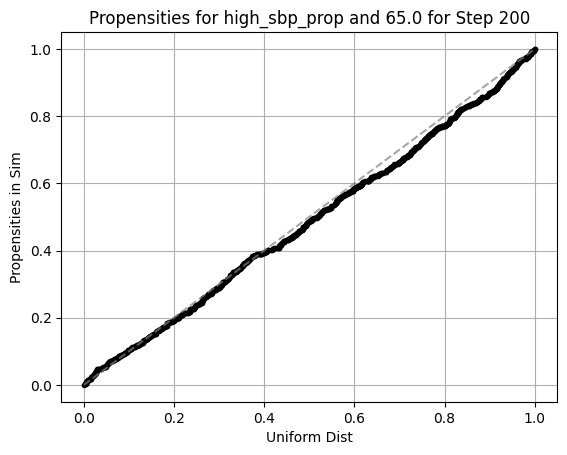

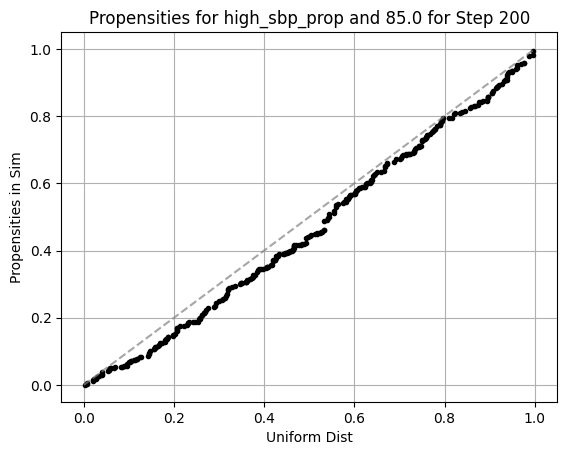

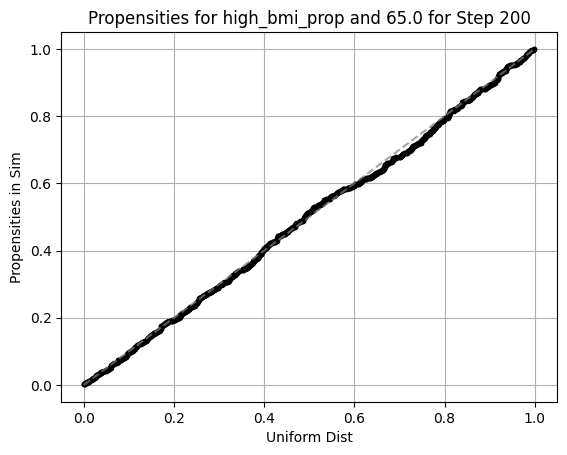

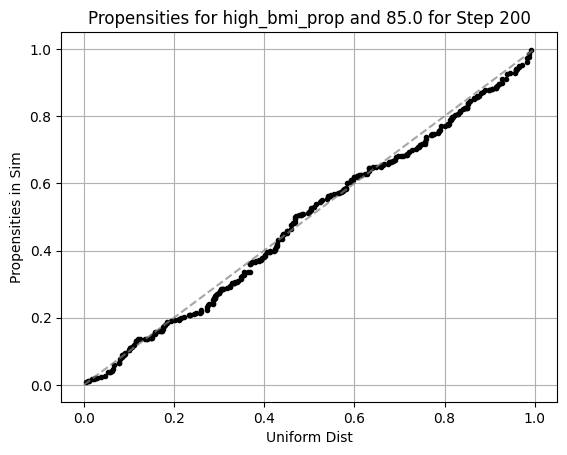

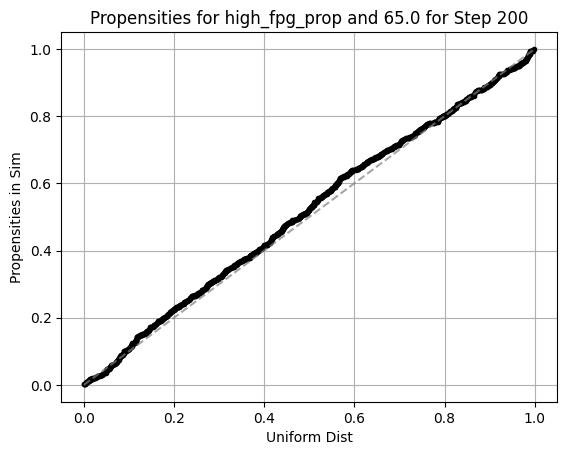

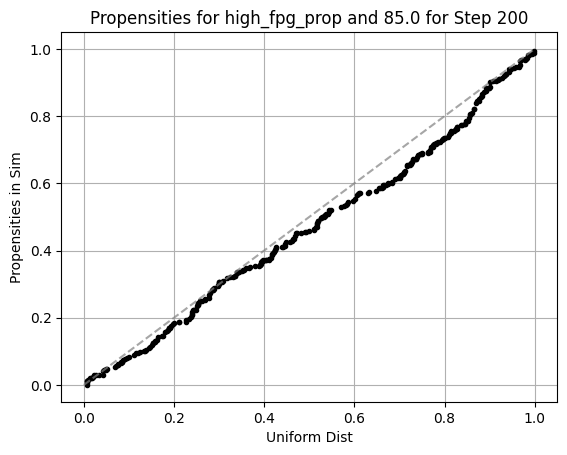

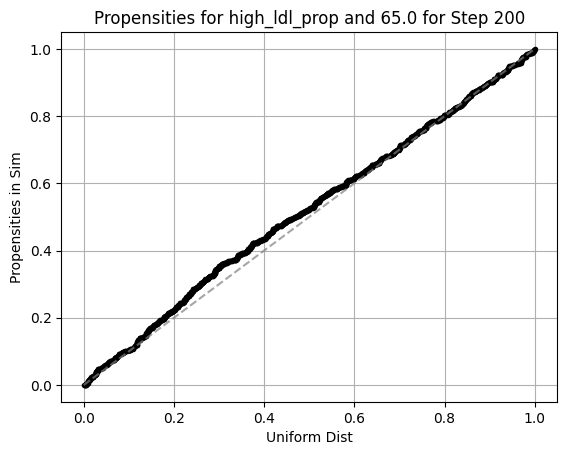

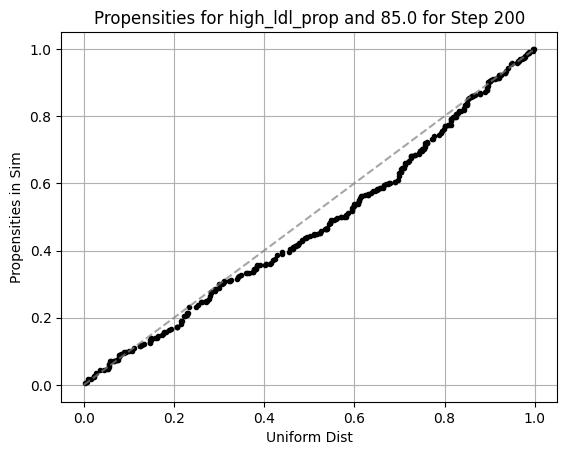

In [16]:
for risk in risks:
    for age in test_data_small.age_start.unique():
        subdata = test_data_small.loc[(test_data_small.age_start == age)]
        plt.figure()
        plt.plot(np.sort(np.random.uniform(size=len(subdata))),
         subdata[risk].sort_values(), 'k.')
        plt.plot([0,1], [0,1], '--', color='grey', alpha=.7)
        plt.grid()
        plt.xlabel('Uniform Dist')
        plt.ylabel('Propensities in Sim');
        plt.title(f'Propensities for {risk} and {age} for Step 200')

## Testing Exposure Compared to Artifact in 2021

In [17]:
from vivarium import Artifact

#explore the artifact data (note age groups)
art = Artifact('/mnt/team/simulation_science/costeffectiveness/artifacts/vivarium_nih_us_cvd/alabama.hdf', filter_terms=['year_start == 2019', 'age_start >=  25'])

In [18]:
def load_artifact_data(word:str, cause:str, measure:str):
    master_art_data = pd.DataFrame()
    for i in ['alabama']: #in case there are other countries
        
        # grab main artifact object
        art = Artifact('/mnt/team/simulation_science/costeffectiveness/artifacts/vivarium_nih_us_cvd/' + i + '.hdf', 
                   filter_terms=['year_start == 2019', 'age_start >=  25']) # << MIGHT WANT TO CHANGE THESE TERMS
        
        # load requested measure
        data = art.load(word + '.' + cause + '.' + measure)
        
        # collapse to desired percentiles
        ## Add in the line for draw_0 here 
        data = data.apply(pd.DataFrame.describe, percentiles=[0.025, 0.35,0.975], axis=1).filter(['mean','35%', '2.5%', '97.5%']).reset_index()
        
        # formatting (may want to format age as well)
        data['location'] = i.capitalize()
        data['measure'] = measure
    
   
        master_art_data = master_art_data.append(data)
        
    return master_art_data

### SBP

In [24]:
sbp_all = art.load('risk_factor.high_systolic_blood_pressure.exposure')
sbp_all.reset_index(inplace=True)
sbp_all.head()

,sex,age_start,age_end,year_start,year_end,parameter,draw_0,draw_1,draw_2,draw_3,...,draw_990,draw_991,draw_992,draw_993,draw_994,draw_995,draw_996,draw_997,draw_998,draw_999
0,Female,25.0,30.0,2019,2020,continuous,109.839770,110.132984,109.036134,108.832792,...,110.279816,110.512266,108.488479,110.149644,107.837399,110.978960,112.243396,112.727692,112.834870,109.133024
1,Female,30.0,35.0,2019,2020,continuous,114.038764,114.288067,111.174207,111.363164,...,110.982448,112.498955,110.800984,113.087076,113.920119,112.472669,111.715609,111.879991,111.604431,112.611431
2,Female,35.0,40.0,2019,2020,continuous,115.260806,114.821917,115.003483,116.208158,...,116.020339,114.974531,116.007230,114.581860,114.784490,117.068174,116.073877,116.883430,116.855510,114.815210
3,Female,40.0,45.0,2019,2020,continuous,120.694393,118.053402,117.444604,118.795341,...,117.629288,119.836959,118.267327,119.508618,118.756802,116.487778,119.856386,116.860545,115.903805,118.436087
4,Female,45.0,50.0,2019,2020,continuous,123.815329,120.648639,118.741245,120.840100,...,119.445030,122.759831,122.765682,119.369064,120.131596,119.638494,122.247631,121.090035,122.196238,120.358378


In [25]:
sbp_art = load_artifact_data('risk_factor', 'high_systolic_blood_pressure', 'exposure')
sbp_art['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(sbp_art.age_start,sbp_art.age_end)]
sbp_art.head()

,sex,age_start,age_end,year_start,year_end,parameter,mean,35%,2.5%,97.5%,location,measure,age_group
0,Female,25.0,30.0,2019,2020,continuous,110.635893,110.098339,107.945700,113.550750,Alabama,exposure,25_to_29
1,Female,30.0,35.0,2019,2020,continuous,112.876275,112.329861,110.098198,115.523727,Alabama,exposure,30_to_34
2,Female,35.0,40.0,2019,2020,continuous,116.139886,115.590512,113.594023,118.770064,Alabama,exposure,35_to_39
3,Female,40.0,45.0,2019,2020,continuous,118.491616,117.983562,115.903577,121.039457,Alabama,exposure,40_to_44
4,Female,45.0,50.0,2019,2020,continuous,121.645391,121.090394,118.875235,124.529834,Alabama,exposure,45_to_49


In [26]:
sbp_exp = (test_data
                .groupby(['age_start', 'sex','step'])
                .high_sbp.describe(percentiles=[.025, .975])
                .filter(['mean','2.5%','97.5%'])
                .reset_index())
sbp_exp = sbp_exp.loc[sbp_exp.age_start < 105]
sbp_exp.head()

,age_start,sex,step,mean,2.5%,97.5%
0,25.0,Female,0,107.360940,90.604693,131.606426
1,25.0,Female,1,107.377780,90.601713,131.616075
2,25.0,Female,2,107.371294,90.584576,130.958241
3,25.0,Female,3,107.352202,90.583086,130.966366
4,25.0,Female,4,107.329252,90.580851,130.585423


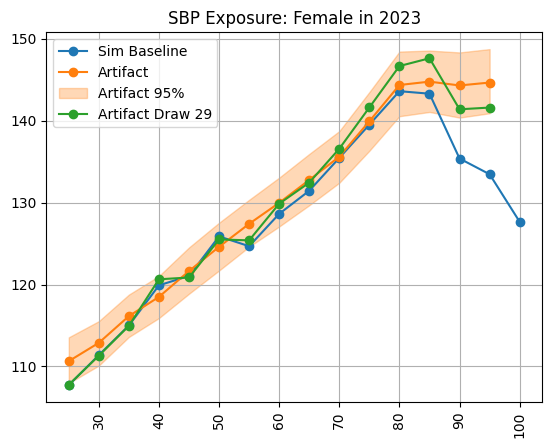

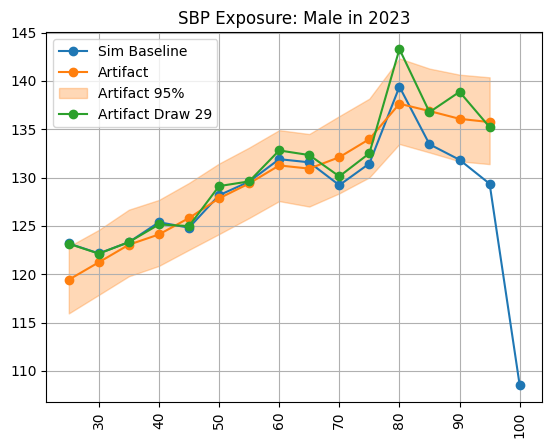

In [27]:
for sex in sbp_exp.sex.unique():
    plt.figure() 
    subdata = sbp_exp.loc[(sbp_exp.sex==sex) & (sbp_exp.step==199)]
    plt.plot(subdata['age_start'], subdata['mean'], marker='o', color = 'C0', label = 'Sim Baseline')
    #plt.fill_between(subdata['age_start'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = sbp_art.loc[(sbp_art.sex==sex) & (sbp_art.year_end==2020)]
    plt.plot(subdata2['age_start'], subdata2['mean'], marker='o', label = 'Artifact', color = 'C1')
    plt.fill_between(subdata2['age_start'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3, label = 'Artifact 95%', color = 'C1')
    subdata3 = sbp_all.loc[(sbp_all.sex==sex)]
    plt.plot(subdata3['age_start'], subdata3['draw_29'], marker='o', label = 'Artifact Draw 29', color = 'C2')
    plt.title(f'SBP Exposure: {sex} in 2023') 
    plt.xticks(rotation=90) 
    #plt.ylim(0,100000)
    plt.grid()
    plt.legend()

Text(0.5, 1.0, 'SBP mean value for 85-90 females over 200 steps')

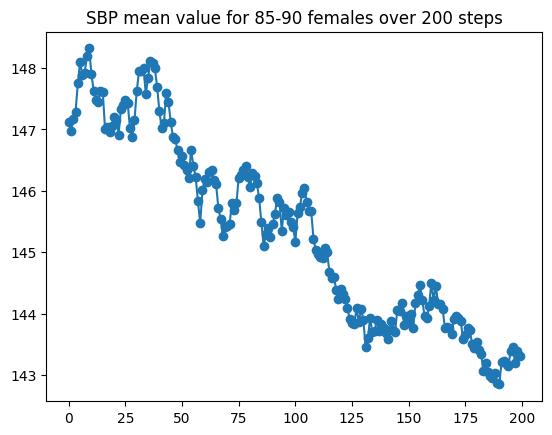

In [28]:
subdata = sbp_exp.loc[(sbp_exp.age_start==85.0) & (sbp_exp.sex=='Female')]
plt.plot(subdata['step'], subdata['mean'], marker='o', color = 'C0')
plt.title('SBP mean value for 85-90 females over 200 steps')

In [18]:
data1.loc[data1.age_start > 100]

,tracked,age,sex,alive,entrance_time,exit_time,location,cause_of_death,years_of_life_lost,years_lived_with_disability,...,scheduled_date,visit_type,high_ldl,high_sbp,high_bmi,high_fpg,hf_ihd,hf_resid,acute_mi,age_start
4700,True,106.524522,Female,alive,2020-12-04,NaT,Alabama,not_dead,0.0,0.0,...,NaT,none,3.328884,187.779511,23.861687,6.119356,0.005735,0.004658,0.002334,105.0
6575,True,108.032306,Male,alive,2020-12-04,NaT,Alabama,not_dead,0.0,0.0,...,2021-02-14 12:33:06.970780800,none,2.808106,137.643584,31.466309,8.347287,0.013222,0.008608,0.007617,105.0


Looks like the ends of the graph is just due to there being only one person in those groups! I removed them for clarity

### LDL-C

In [18]:
ldl_art_all = art.load('risk_factor.high_ldl_cholesterol.exposure')
ldl_art_all = ldl_art_all.loc[ldl_art_all.index.get_level_values('age_start') > 70]
ldl_small = ldl_art_all.apply(pd.DataFrame.describe, percentiles=[0.65], axis=1).filter(['65%']).reset_index()
ldl_small.mean()

/tmp/ipykernel_26825/2109636798.py:4: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  ldl_small.mean()


age_start       85.000000
age_end         95.000000
year_start    2019.000000
year_end      2020.000000
65%              2.910916
dtype: float64

In [19]:
ldl_art = load_artifact_data('risk_factor', 'high_ldl_cholesterol', 'exposure')
ldl_art['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(ldl_art.age_start,ldl_art.age_end)]
ldl_art.head()

/tmp/ipykernel_26825/3135475009.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  master_art_data = master_art_data.append(data)


,sex,age_start,age_end,year_start,year_end,parameter,mean,35%,2.5%,97.5%,location,measure,age_group
0,Female,25.0,30.0,2019,2020,continuous,2.639862,2.600945,2.472574,2.821188,Alabama,exposure,25_to_29
1,Female,30.0,35.0,2019,2020,continuous,2.724353,2.691550,2.553736,2.905134,Alabama,exposure,30_to_34
2,Female,35.0,40.0,2019,2020,continuous,2.802925,2.772667,2.639513,2.972487,Alabama,exposure,35_to_39
3,Female,40.0,45.0,2019,2020,continuous,2.880791,2.850118,2.721814,3.039119,Alabama,exposure,40_to_44
4,Female,45.0,50.0,2019,2020,continuous,2.998297,2.963904,2.837974,3.175367,Alabama,exposure,45_to_49


In [21]:
ldl_exp = (test_data
                .groupby(['age_start', 'sex', 'step'])
                .high_ldl.describe(percentiles=[.025, 0.35,.975])
                .filter(['mean','35%','2.5%','97.5%'])
                .reset_index())
ldl_exp.head()

,age_start,sex,step,mean,35%,2.5%,97.5%
0,25.0,Female,0,2.859961,2.468483,1.428689,4.718621
1,25.0,Female,1,2.858048,2.466709,1.428646,4.698637
2,25.0,Female,2,2.862467,2.479899,1.421438,4.711734
3,25.0,Female,3,2.864555,2.478882,1.420981,4.712873
4,25.0,Female,4,2.860917,2.478837,1.420296,4.675372


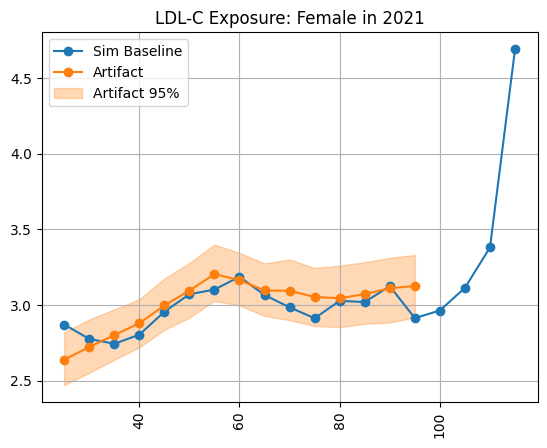

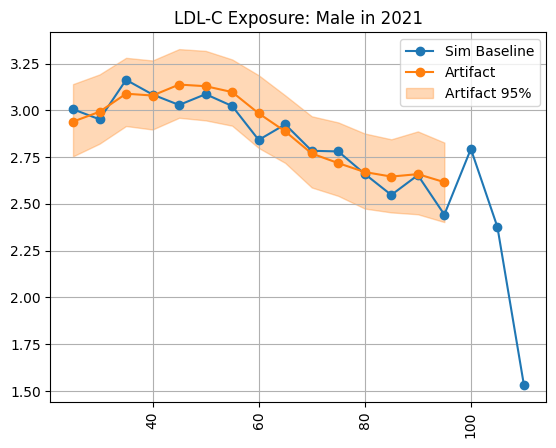

In [22]:
for sex in ldl_exp.sex.unique():
    plt.figure() 
    subdata = ldl_exp.loc[(ldl_exp.sex==sex) & (ldl_exp.step==24)]
    plt.plot(subdata['age_start'], subdata['mean'], marker='o', color = 'C0', label = 'Sim Baseline')
    #plt.fill_between(subdata['age_start'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = ldl_art.loc[(ldl_art.sex==sex) & (ldl_art.year_end==2020)]
    plt.plot(subdata2['age_start'], subdata2['mean'], marker='o', label = 'Artifact', color = 'C1')
    plt.fill_between(subdata2['age_start'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3, label = 'Artifact 95%', color = 'C1')
    plt.title(f'LDL-C Exposure: {sex} in 2021') 
    plt.xticks(rotation=90) 
    #plt.ylim(0,100000)
    plt.grid()
    plt.legend() 

In [22]:
data1.loc[data1.age_start == 100]

,tracked,age,sex,alive,entrance_time,exit_time,location,cause_of_death,years_of_life_lost,years_lived_with_disability,...,scheduled_date,visit_type,high_ldl,high_sbp,high_bmi,high_fpg,hf_ihd,hf_resid,acute_mi,age_start
2108,True,101.601737,Female,alive,2020-12-04,NaT,Alabama,not_dead,0.0,0.0,...,NaT,none,1.806020,194.654956,28.820533,5.647478,0.006498,0.005278,0.002028,100.0
2285,True,104.867639,Female,alive,2020-12-04,NaT,Alabama,not_dead,0.0,0.0,...,NaT,none,3.409409,131.617414,25.428487,9.634173,0.005316,0.004318,0.001913,100.0
4871,True,104.731512,Male,alive,2020-12-04,NaT,Alabama,not_dead,0.0,0.0,...,NaT,none,2.022770,134.074676,30.117374,8.114999,0.012780,0.008320,0.005216,100.0
7436,True,100.593125,Male,alive,2020-12-04,NaT,Alabama,not_dead,0.0,0.0,...,NaT,none,4.106867,129.441540,30.292312,6.212580,0.010671,0.006947,0.004901,100.0
7744,True,100.136283,Female,alive,2020-12-04,NaT,Alabama,not_dead,0.0,0.0,...,NaT,none,2.881371,138.752634,20.549861,4.270128,0.004938,0.004010,0.000552,100.0
8042,True,104.439608,Female,alive,2020-12-04,NaT,Alabama,not_dead,0.0,0.0,...,NaT,none,1.577250,138.738971,19.741234,5.641705,0.004938,0.004010,0.000462,100.0


Again, the issues at the end of the graph look like they are due to small samples

## BMI too

In [23]:
bmi_art = load_artifact_data('risk_factor', 'high_body_mass_index_in_adults', 'exposure')
bmi_art['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(bmi_art.age_start,bmi_art.age_end)]
bmi_art.head()

/tmp/ipykernel_26825/3135475009.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  master_art_data = master_art_data.append(data)


,sex,age_start,age_end,year_start,year_end,parameter,mean,35%,2.5%,97.5%,location,measure,age_group
0,Female,25.0,30.0,2019,2020,continuous,30.899912,30.834806,30.572156,31.233780,Alabama,exposure,25_to_29
1,Female,30.0,35.0,2019,2020,continuous,31.636913,31.572002,31.293987,31.989474,Alabama,exposure,30_to_34
2,Female,35.0,40.0,2019,2020,continuous,31.883495,31.819942,31.555235,32.210906,Alabama,exposure,35_to_39
3,Female,40.0,45.0,2019,2020,continuous,32.130649,32.065292,31.801051,32.462829,Alabama,exposure,40_to_44
4,Female,45.0,50.0,2019,2020,continuous,32.169931,32.101729,31.855765,32.505542,Alabama,exposure,45_to_49


In [24]:
bmi_exp = (test_data
                .groupby(['age_start', 'sex','step'])
                .high_bmi.describe(percentiles=[.025, .975])
                .filter(['mean','2.5%','97.5%'])
                .reset_index())
bmi_exp = bmi_exp.loc[bmi_exp.age_start < 105]
bmi_exp.head()

,age_start,sex,step,mean,2.5%,97.5%
0,25.0,Female,0,31.052349,17.021920,53.440263
1,25.0,Female,1,31.058782,17.037296,53.421717
2,25.0,Female,2,31.015495,16.918000,53.420464
3,25.0,Female,3,30.999316,16.946285,53.420685
4,25.0,Female,4,31.025707,16.916763,53.630475


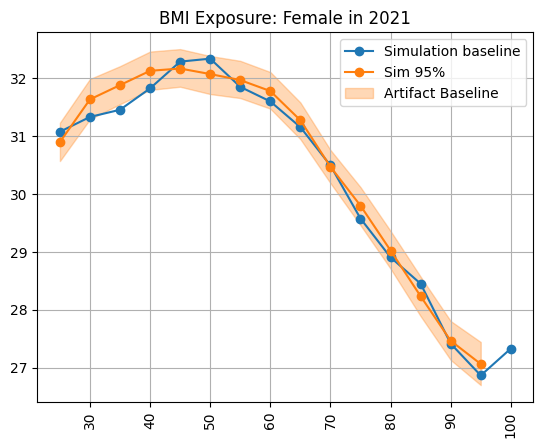

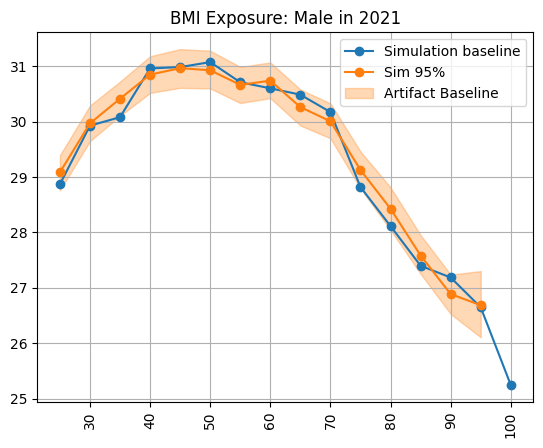

In [25]:
for sex in bmi_exp.sex.unique():
    plt.figure() 
    subdata = bmi_exp.loc[(bmi_exp.sex==sex) & (bmi_exp.step==24)]
    plt.plot(subdata['age_start'], subdata['mean'], marker='o', color = 'C0', label = 'Sim Baseline')
    #plt.fill_between(subdata['age_start'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = bmi_art.loc[(bmi_art.sex==sex) & (bmi_art.year_end==2020)]
    plt.plot(subdata2['age_start'], subdata2['mean'], marker='o', label = 'Artifact', color = 'C1')
    plt.fill_between(subdata2['age_start'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3, label = 'Artifact 95%', color = 'C1')
    plt.title(f'BMI Exposure: {sex} in 2021') 
    plt.xticks(rotation=90) 
    #plt.ylim(0,100000)
    plt.grid()
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 

Text(0.5, 1.0, 'BMI mean value for 85-90 females over 25 steps')

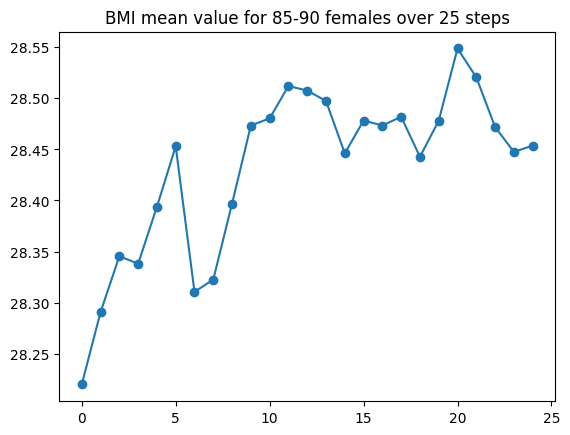

In [34]:
subdata = bmi_exp.loc[(bmi_exp.age_start==85.0) & (bmi_exp.sex=='Female')]
plt.plot(subdata['step'], subdata['mean'], marker='o', color = 'C0')
plt.title('BMI mean value for 85-90 females over 25 steps')